<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import pandas as pd
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-03-07 20:23:27--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-03-07 20:23:27 (13.9 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to understand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following packages will be UPDATED:

    seaborn: 0.8.0-py35h15a2772_0 --> 0.9.0-py35_0 anaconda

seaborn-0.9.0- 100% |################################| Time: 0:00:00  16.01 MB/s


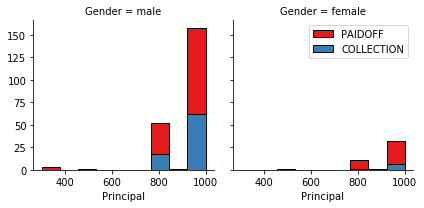

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

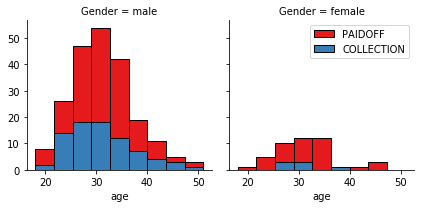

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

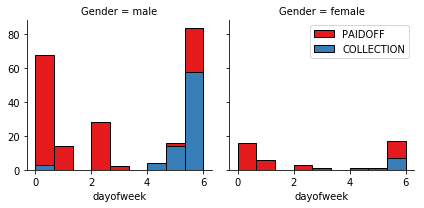

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our labels?

In [18]:
y = df['loan_status'].values
y_labels=set(y)
print (y[0:5])
print (y_labels)

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
{'PAIDOFF', 'COLLECTION'}


## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)

Train set: (276, 8) (276,)


In [21]:
from sklearn.neighbors import KNeighborsClassifier
k = 7
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat_KNN = neigh.predict(X_test)
print(yhat_KNN[0:5])
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_KNN))

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Train set Accuracy:  0.807971014493
Test set Accuracy:  0.785714285714


### Find the best K

In [22]:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
print( "Mean accuracies were:", mean_acc )

Mean accuracies were: [ 0.67142857  0.65714286  0.71428571  0.68571429  0.75714286  0.71428571
  0.78571429  0.75714286  0.75714286  0.67142857  0.7         0.72857143
  0.7         0.7         0.68571429  0.72857143  0.72857143  0.72857143
  0.7       ]


### Plot the accuracy of different values of K

And here's the plot for : K Nearest Neighbour


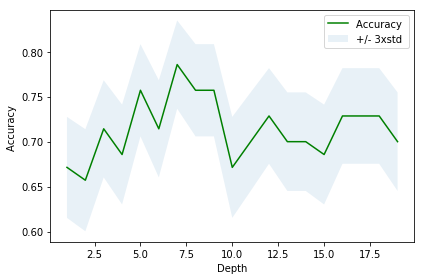

The best accuracy was with 0.785714285714 with K Nearest Neighbour = 7


In [55]:
# and plot
def plotComparison(label, min, max, mean_acc, std_acc):
    print( "And here's the plot for :", label )
    plt.plot(range(min, max), mean_acc, 'g')
    plt.fill_between(range(1, max), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10)
    plt.legend(('Accuracy ', '+/- 3xstd'))
    plt.ylabel('Accuracy ')
    plt.xlabel('Depth')
    plt.tight_layout()
    plt.show()
    print( "The best accuracy was with", mean_acc.max(), "with", label, "=", mean_acc.argmax()+1)
    return mean_acc.argmax()+1
    
bestK = plotComparison("K Nearest Neighbour", 1, Ks, mean_acc, std_acc)

In [56]:
bestKNN = KNeighborsClassifier(n_neighbors = bestK)

# Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

In [25]:
# Inside of the classifier, specify criterion="entropy" so we can see the information gain of each node.
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 7)
print(loanTree)
loanTree.fit(X_trainset,y_trainset)
yhat_tree = loanTree.predict(X_testset)
#print (yhat_tree [0:5])
#print (y_testset [0:5])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


### Find the best K

Original DecisionTrees's Accuracy:  0.663461538462
Mean accuracies were: [ 0.74  0.74  0.67  0.65  0.68  0.7   0.66  0.66  0.64  0.64  0.64  0.65
  0.65  0.65  0.65  0.65  0.65  0.65  0.65]
Std accuracies were: [ 0.04  0.04  0.05  0.05  0.05  0.04  0.05  0.05  0.05  0.05  0.05  0.05
  0.05  0.05  0.05  0.05  0.05  0.05  0.05]
And here's the plot for : k


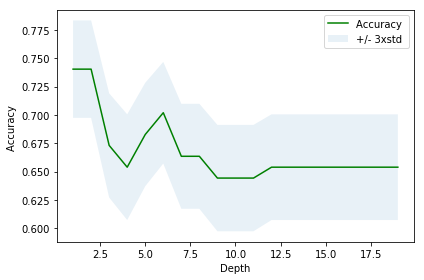

The best accuracy was with 0.740384615385 with k = 1


1

In [67]:
# Check the accuracy
from sklearn import metrics
import matplotlib.pyplot as plt
print("Original DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, yhat_tree))
max_k=20
tree_mean_acc = np.zeros((max_k-1))
tree_std_acc = np.zeros((max_k-1))

# compare different depths
for k in range(1, max_k):
    #Train ModelDecisionTreeClassifier(criterion="entropy", max_depth = 7) and Predict  
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = k)
    loanTree.fit(X_trainset,y_trainset)
    yhat = loanTree.predict(X_testset)
    tree_mean_acc[k-1] = metrics.accuracy_score(y_testset, yhat)
    tree_std_acc[k-1] = np.std(yhat==y_testset)/np.sqrt(yhat.shape[0])
print( "Mean accuracies were:", tree_mean_acc )
print( "Std accuracies were:", tree_std_acc )

# and plot
def plotComparison(label, min, max, mean_acc, std_acc):
    print( "And here's the plot for :", label )
    plt.plot(range(min, max), mean_acc, 'g')
    plt.fill_between(range(min, max), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10)
    plt.legend(('Accuracy ', '+/- 3xstd'))
    plt.ylabel('Accuracy ')
    plt.xlabel('Depth')
    plt.tight_layout()
    plt.show()
    print( "The best accuracy was with", mean_acc.max(), "with", label, "=", mean_acc.argmax()+1)
    return mean_acc.argmax()+1
    
plotComparison("k", 1, max_k, tree_mean_acc, tree_std_acc)

In [27]:
bestDTree = DecisionTreeClassifier(criterion="entropy", max_depth = 1)
bestDTree.fit(X_trainset, y_trainset)
yhat_DTree = bestDTree.predict(X_testset)

### Draw the tree

In [28]:
## Notice: You the conda install takes a while, so this section commented out and not required for the rest of the cells to work.
## Only uncomment the code in this cell if you are curious about how the tree looks
## (to uncomment: select all lines below this in the cell then press Ctrl and '/')
## Uncomment below here if curious:

#  !conda install -c conda-forge pydotplus -y
#  !conda install -c conda-forge python-graphviz -y

# from sklearn.externals.six import StringIO
# import pydotplus
# import matplotlib.image as mpimg
# from sklearn import tree
# %matplotlib inline

## Best decision tree accuracy was with depth 1 and 2, but with a 2nd peak at depth 4. Use depth 4 for illustration
# loanTreeToDisplay = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
# loanTreeToDisplay.fit(X_trainset,y_trainset)

# def plotTree(filename, treeToDisplay):
#     dot_data = StringIO()
#     featureNames = Feature.columns
#     targetNames = np.unique(y)
#     out=tree.export_graphviz(treeToDisplay, feature_names=featureNames, out_file=dot_data, class_names=np.unique(y_trainset), filled=True, special_characters=True, rotate=False)  
#     graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#     graph.write_png(filename)
#     img = mpimg.imread(filename)
#     plt.figure(figsize=(80, 160))
#     plt.imshow(img,interpolation='nearest')

# plotTree("loantree.png", loanTreeToDisplay)

# Support Vector Machine (SVM)

In [29]:
from sklearn import svm
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
# make predictions
yhat = clf.predict(X_test)
yhat [0:5]
bestSVM = clf

## Evaluate SVM

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

             precision    recall  f1-score   support

 COLLECTION       0.36      0.27      0.31        15
    PAIDOFF       0.81      0.87      0.84        55

avg / total       0.72      0.74      0.73        70

Confusion matrix, without normalization
[[48  7]
 [11  4]]


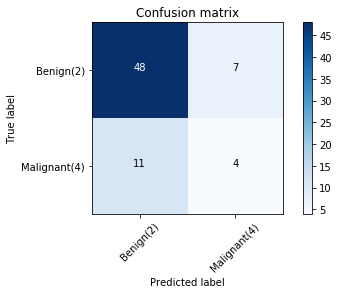

In [32]:
# Compute confusion matrix
#print(y_test[0:5])
#print(yhat[0:5])
y_labels=list(set(y_test))
#print (y_labels)
cnf_matrix = confusion_matrix(y_test, yhat, labels=y_labels)

np.set_printoptions(precision=2)
print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'], normalize= False, title='Confusion matrix')

In [33]:
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
print("Avg F1-score: %.4f" % f1_score(y_test, yhat, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat))
yhat_SVM = yhat

Avg F1-score: 0.7276
Jaccard score: 0.7429


### Find the best K

### Evaluate different SVM Kernels:

In [34]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for k in kernels:
    clf = svm.SVC(kernel=k)
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    print(k, "Avg F1-score: %.4f" % f1_score(y_test, yhat, average='weighted'))
    print(k, "Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat))
    print("----------------------------")
    
print ("best k, using F1 score = rbf; best k using Jaccard score = linear")

linear Avg F1-score: 0.6914
linear Jaccard score: 0.7857
----------------------------
poly Avg F1-score: 0.7065
poly Jaccard score: 0.7714
----------------------------
rbf Avg F1-score: 0.7276
rbf Jaccard score: 0.7429
----------------------------
sigmoid Avg F1-score: 0.6893
sigmoid Jaccard score: 0.7429
----------------------------
best k, using F1 score = rbf; best k using Jaccard score = linear


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
#******************** HERE *********************
# TESTING OUT KERNEL + C evaluation
###################################################

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
Cs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

max_k = len(Cs)
svm_bestKperKernel = []
bestOverallAccuracy = 0
for kernel in kernels:
    f1_scores = np.zeros((max_k-1))
    for k in range(1, max_k):
        clf = svm.SVC(C=Cs[k-1], kernel=kernel)
        clf.fit(X_train, y_train)
        yhat = clf.predict(X_test)
        f1_scores[k-1] = f1_score(y_test, yhat, average='weighted')
        
    print( "F1 Scores for kernel ", kernel, "were:", f1_scores)
    
    # find the best K for this solver
    bestKernelAccuracy = f1_scores.max()
    bestKernelK = f1_scores.argmax()
    #print( "The best accuracy for Kernel ", kernel, "was", bestKernelAccuracy, "with C =", Cs[bestKernelK])
    svm_bestKperKernel += ((kernel, bestKernelAccuracy, Cs[bestKernelK]))
    if (bestKernelAccuracy > bestOverallAccuracy):
        bestOverallAccuracy = bestKernelAccuracy
        (bestKernel, bestAccuracy, bestK) = (kernel, bestKernelAccuracy, bestKernelK)
print (svm_bestKperKernel)
print ("\nThe best f1_score per Kernel:", svm_bestKperKernel)

print ("\n*** The best combination of kernel and C was: ", bestKernel, "and C=", Cs[bestK], "with accuracy", bestKernelAccuracy)

F1 Scores for kernel  linear were: [ 0.69  0.69  0.69  0.69  0.69  0.69  0.69]
F1 Scores for kernel  poly were: [ 0.69  0.69  0.69  0.69  0.69  0.71  0.66]
F1 Scores for kernel  rbf were: [ 0.69  0.69  0.69  0.69  0.69  0.73  0.65]
F1 Scores for kernel  sigmoid were: [ 0.69  0.69  0.69  0.69  0.69  0.69  0.68]
['linear', 0.69142857142857139, 1e-05, 'poly', 0.70647931303668987, 1, 'rbf', 0.72758820127241175, 1, 'sigmoid', 0.69142857142857139, 1e-05]

The best f1_score per Kernel: ['linear', 0.69142857142857139, 1e-05, 'poly', 0.70647931303668987, 1, 'rbf', 0.72758820127241175, 1, 'sigmoid', 0.69142857142857139, 1e-05]

*** The best combination of kernel and C was:  rbf and C= 1 with accuracy 0.691428571429


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
bestSVM = svm.SVC(C=Cs[bestK], kernel=bestKernel)

# Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat_LR = LR.predict(X_test)
yhat_LR_prob = LR.predict_proba(X_test)

In [38]:
k = "Logistic Regression"
from sklearn.metrics import log_loss
LogRegResults = (k, log_loss(y_test, yhat_LR_prob), f1_score(y_test, yhat_LR, average='weighted'), jaccard_similarity_score(y_test, yhat_LR))

print(k, "Avg Logloss-score: %.4f" % log_loss(y_test, yhat_LR_prob))
print(k, "Avg F1-score: %.4f" % f1_score(y_test, yhat_LR, average='weighted'))
print(k, "Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat_LR))

Logistic Regression Avg Logloss-score: 0.5772
Logistic Regression Avg F1-score: 0.6671
Logistic Regression Jaccard score: 0.6857


### Find the best K: Compare solvers and C values

In [39]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
Cs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

max_k = len(Cs)
lr_bestKperSolver = []
bestOverallAccuracy = 0
for s in solvers:
    lr_logloss = np.zeros((max_k-1))
    for k in range(1, max_k):
        LR = LogisticRegression(C=Cs[k-1], solver=s).fit(X_train,y_train)
        yhat_prob = LR.predict_proba(X_test)
        lr_logloss[k-1] = log_loss(y_test, yhat_prob)
    print( "LogLosses for solver ", s, "were:", lr_logloss)
    
    # find the best K for this solver
    bestSolverAccuracy = lr_logloss.max()
    bestSolverK = lr_logloss.argmax()
    #print( "The best accuracy for solver ", s, "was", bestSolverAccuracy, "with C =", Cs[bestSolverK])
    lr_bestKperSolver += ((s, bestSolverAccuracy, Cs[bestSolverK]))
    if (bestSolverAccuracy > bestOverallAccuracy):
        bestOverallAccuracy = bestSolverAccuracy
        (bestSolver, bestAccuracy, bestK) = (s, bestSolverAccuracy, bestSolverK)
print ("\nThe best accuracy per Solver:", lr_bestKperSolver)

print ("\nThe best combination of solver and C was: ", bestSolver, Cs[bestK], "with accuracy", bestAccuracy)

LogLosses for solver  newton-cg were: [ 0.52  0.52  0.52  0.49  0.48  0.5 ]
LogLosses for solver  lbfgs were: [ 0.52  0.52  0.52  0.49  0.48  0.5 ]
LogLosses for solver  liblinear were: [ 0.69  0.69  0.67  0.58  0.5   0.5 ]
LogLosses for solver  sag were: [ 0.52  0.52  0.52  0.49  0.48  0.5 ]
LogLosses for solver  saga were: [ 0.52  0.52  0.52  0.49  0.48  0.5 ]

The best accuracy per Solver: ['newton-cg', 0.52453315530482536, 1e-05, 'lbfgs', 0.52453316729112787, 1e-05, 'liblinear', 0.69289991361997383, 1e-05, 'sag', 0.52470903448754491, 1e-05, 'saga', 0.52485890386605483, 1e-05]

The best combination of solver and C was:  liblinear 1e-05 with accuracy 0.69289991362


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [40]:
bestLR = LogisticRegression(C=Cs[bestK], solver=bestSolver)

## Compare how the various models performed against the _Train/Test_ Set

The best logistic regression classifier was liblinear using a C of 0.0001

In [41]:
yhat_DTree = bestDTree.predict(X_test)
KNNScores = ('KNN', jaccard_similarity_score(y_test, yhat_KNN), f1_score(y_test, yhat_KNN, average='weighted'), 'NA')
DTreeScores = ('Decision Tree', jaccard_similarity_score(y_test, yhat_DTree), f1_score(y_test, yhat_DTree, average='weighted'), 'NA')
SVMScores = ('SVM', jaccard_similarity_score(y_test, yhat_SVM), f1_score(y_test, yhat_SVM, average='weighted'), 'NA')
LogRegScores = ('LogisticRegression', jaccard_similarity_score(y_test, yhat_LR), f1_score(y_test, yhat_LR, average='weighted'), log_loss(y_test, yhat_LR_prob))

data = [KNNScores, DTreeScores, SVMScores, LogRegScores]
pd.DataFrame(data, columns=('Algorithm', 'Jaccard', 'F1-score', 'LogLoss'), index=['','','',''])

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Algorithm,Jaccard,F1-score,LogLoss
,KNN,0.785714,0.776654,NA
,Decision Tree,0.785714,0.691429,NA
,SVM,0.742857,0.727588,NA
,LogisticRegression,0.685714,0.667052,0.577229


# Model Evaluation using Test set

In [42]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [43]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-03-07 20:24:23--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-03-07 20:24:24 (708 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [44]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Prepare Data for use

In [45]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [46]:
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

### Derive numeric fields and create Feature set

In [47]:
### Derive useful fields as numeric values
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male', 'female'], value=[0,1], inplace=True)

### One-hot encoding
Test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
Test_Feature = pd.concat([Test_Feature, pd.get_dummies(test_df['education'])], axis=1)
Test_Feature.drop(['Master or Above'], axis = 1, inplace=True)
Test_Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


### Define and normalize Evaluation set

In [48]:
X_eval = Test_Feature
y_eval = test_df['loan_status'].values
y_eval_labels=set(y_eval)

X_eval = preprocessing.StandardScaler().fit(X_eval).transform(X_eval)

### Evaluate Models using Evaluation data

In [72]:
# Now setup the classifiers using the whole of the original train/test dataset to fit the models
# then predict against the evaluatin data.

# KNN
bestKNN.fit(X, y) # train on original test set
yhat_eval_KNN = optimumKNNClassifier.predict(X_eval)

# SVM
bestSVM.fit(X, y) # train on original test set
yhat_eval_SVM = bestSVM.predict(X_eval)

# DTree
bestDTree.fit(X, y) # train on original test set
yhat_eval_DTree = bestDTree.predict(X_eval)

# LogReg
LR_eval = bestLR.fit(X, y) # train on original test set
yhat_eval_LR = LR_eval.predict(X_eval)
yhat_eval_LR_prob = LR_eval.predict_proba(X_eval)

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

### Summarize and display the comparison

In [73]:
# and evaluate table
EvalKNNScores = ('KNN', jaccard_similarity_score(y_eval, yhat_eval_KNN), f1_score(y_eval, yhat_eval_KNN, average='weighted'), 'NA')
EvalDTreeScores = ('Decision Tree', jaccard_similarity_score(y_eval, yhat_eval_DTree), f1_score(y_eval, yhat_eval_DTree, average='weighted'), 'NA')
EvalSVMScores = ('SVM', jaccard_similarity_score(y_eval, yhat_eval_SVM), f1_score(y_eval, yhat_eval_SVM, average='weighted'), 'NA')
EvalLogRegScores = ('LogisticRegression', jaccard_similarity_score(y_eval, yhat_eval_LR), f1_score(y_eval, yhat_eval_LR, average='weighted'), log_loss(y_eval, yhat_eval_LR_prob))
eval_data = [EvalKNNScores, EvalDTreeScores, EvalSVMScores, EvalLogRegScores]
pd.DataFrame(eval_data, columns=('Algorithm', 'Jaccard', 'F1-score', 'LogLoss'), index=['','','',''])

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Algorithm,Jaccard,F1-score,LogLoss
,KNN,0.722222,0.700199,NA
,Decision Tree,0.740741,0.630418,NA
,SVM,0.722222,0.621266,NA
,LogisticRegression,0.759259,0.671764,0.692819


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>